In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision,tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install opencv-python

In [3]:
!python -c "import SimpleITK" || pip install -q SimpleITK
!python -c "import medpy" || pip install -q medpy

In [4]:
import monai
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import medpy
import PIL
import cv2

In [5]:
from monai.config import print_config
print_config()

MONAI version: 0.6.0
Numpy version: 1.24.1
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
import os
import shutil
import tempfile
from pathlib import Path

### Set Data Directory to where you want all the data and processing artifacts to be

If using Kaggle

In [ ]:
%env DATA_DIRECTORY = /kaggle/input

If using Google Drive

In [ ]:
%env DATA_DIRECTORY = /content/drive/MyDrive/LVEF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

If using a local directory

In [7]:
%env DATA_DIRECTORY = C:\Workspace\Practice\Python\PyTorch

env: DATA_DIRECTORY=C:\Workspace\Practice\Python\PyTorch


### Set the Root Directory

In [8]:
directory = os.environ.get("DATA_DIRECTORY")
ROOT_DIR = Path(tempfile.mkdtemp()) if directory is None else Path(directory)
print(ROOT_DIR)

C:\Workspace\Practice\Python\PyTorch


In [9]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

Get the data and setup the input directories

In [10]:
ECHONET_DATA_DIR = 'heartdatabase/EchoNet-Dynamic'

In [11]:
import pprint
pp = pprint.PrettyPrinter()
from monai.utils import set_determinism
set_determinism(seed=0)
from monai.apps import download_and_extract, extractall

In [12]:
## Note that if downloaded then the data will be zippped. It should just 
## unzip at the location. Not tested//
compressed_file = ROOT_DIR.joinpath("data.zip")
DATA_DIR = ROOT_DIR.joinpath(ECHONET_DATA_DIR)
if not os.path.exists(DATA_DIR):
    extractall(compressed_file, ROOT_DIR)
checkPathExists(DATA_DIR)

Path C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic accessible


Load the Info files and the volume traced files

In [13]:
INFO_FILE = DATA_DIR.joinpath('FileList.csv')
VOL_TRACE_FILE = DATA_DIR.joinpath('VolumeTracings.csv')
checkPathExists(INFO_FILE)
checkPathExists(VOL_TRACE_FILE)

Path C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\FileList.csv accessible
Path C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\VolumeTracings.csv accessible


In [14]:
INFO_DF = pd.read_csv(INFO_FILE)
VOL_TRACE_DF = pd.read_csv(VOL_TRACE_FILE)

In [91]:
INFO_DF.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [16]:
VOL_TRACE_DF.head()

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46


In [17]:
INFO_DF.Split.value_counts()

TRAIN    7465
VAL      1288
TEST     1277
Name: Split, dtype: int64

In [19]:
def extractEDandESframes(image_file, ED_frame_number, ES_frame_number):
    video = cv2.VideoCapture(str(image_file))
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    ## Retrieve the ED frame
    for i in range(ED_frame_number-1):
        ret, frame = video.read()
    res, ED_frame = video.read()
    ## Retrieve the ES frame
    diff = ES_frame_number - ED_frame_number
    for i in range(diff):
        ret, frame = video.read()
    res1, ES_frame = video.read()
    if not res:
        print("issue ED")
    if not res1:
        print("issue ES")
    if res&res1:
        return ED_frame, ES_frame
    else:
        return None, None

In [72]:
def saveEDandESimages(data_dir, output_dir, info_df, trace_df):
    patient_list = [x for x in data_dir.iterdir()]
    
    for i, file in enumerate(patient_list):
        patient_id = file.name.split('.')[0]
        frame_df = trace_df.query(f"FileName == '{file.name}'")
        try:
            ed_number, es_number = frame_df.Frame.unique()
        except:
            print(f"This {file} generated an error")
            continue
        split_value = info_df.query(f"FileName == '{patient_id}'").Split
        #print(ed_number, es_number)
        ED_frame, ES_frame = extractEDandESframes(file, ed_number, es_number)
        if ED_frame is not None or ES_frame is not None:
            ## Write the ED and ES frames as images
            iED_path = output_dir.joinpath(f"{patient_id}_ED.png")
            iES_path = output_dir.joinpath(f"{patient_id}_ES.png")
            cv2.imwrite(str(iED_path), ED_frame)
            cv2.imwrite(str(iES_path), ES_frame)
            ## Write the trac points into a csv file
            ED_info = frame_df.query(f'FileName =="{file.name}" and Frame == {ed_number}').reset_index(drop=True)
            ES_info = frame_df.query(f'FileName =="{file.name}" and Frame == {es_number}').reset_index(drop=True)
            ES_info = frame_df.query(f'FileName =="{file.name}" and Frame == {es_number}').reset_index(drop=True)
            ED_stack = np.hstack(ED_info[['X1', 'Y1', 'X2', 'Y2']].values).tolist()
            ES_stack = np.hstack(ES_info[['X1', 'Y1', 'X2', 'Y2']].values).tolist()
            keypoint_df = pd.DataFrame([ED_stack, ES_stack])
            keypoint_df['Image'] = [f"{patient_id}_ED.png", f"{patient_id}_ES.png"]
            keypoint_df['Split'] = [split_value.iloc[0], split_value.iloc[0]]
            keypoint_df.to_csv(output_dir.joinpath(f"{patient_id}.csv"), index=False)
        else:
            print(f"There was an issue with processing {file}")

In [73]:
VIDEO_DIR = DATA_DIR.joinpath('Videos')
#OUTPUT_DIR = Path('/kaggle/working')
OUTPUT_DIR = DATA_DIR.joinpath('Output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
checkPathExists(OUTPUT_DIR)
saveEDandESimages(VIDEO_DIR, OUTPUT_DIR, INFO_DF, VOL_TRACE_DF)

Path C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\Output accessible
This C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\Videos\0X234005774F4CB5CD.avi generated an error
This C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\Videos\0X2DC68261CBCC04AE.avi generated an error
This C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\Videos\0X35291BE9AB90FB89.avi generated an error
This C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\Videos\0X5515B0BD077BE68A.avi generated an error
This C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\Videos\0X5DD5283AC43CCDD1.avi generated an error
This C:\Workspace\Practice\Python\PyTorch\heartdatabase\EchoNet-Dynamic\Videos\0X6C435C1B417FDE8A.avi generated an error


51.80729167


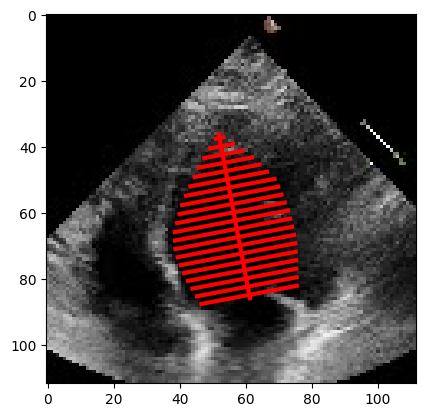

In [90]:
NUM_KEYPOINTS = 84
trace_df = pd.read_csv(OUTPUT_DIR.joinpath('0X10B7505562B0A702.csv'))
arr = PIL.Image.open(str(OUTPUT_DIR.joinpath('0X10B7505562B0A702_ED.png')))
plt.imshow(arr)
df = trace_df.query('Image == "0X10B7505562B0A702_ED.png"')
print(df.iloc[0][0])
for i in range(0, NUM_KEYPOINTS, 4):
    x1, y1 = df.iloc[0][i], df.iloc[0][i+1]
    x2, y2 = df.iloc[0][i+2], df.iloc[0][i+3]
    plt.plot([x1, x2], [y1, y2], color='red', linewidth=3)
plt.show()

### Build a Key Point Detection Model

In [1]:
# Models 
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten

In [3]:
IMAGE_SIZE=112
backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

9406464/9406464 [==============================] - 0s 0us/step
